In [1]:
import os

kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")

if os.path.exists(kaggle_path):
    print("kaggle.json already exists.")
else:
    from google.colab import files
    files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("kaggle.json uploaded and configured.")

Saving kaggle.json to kaggle.json
kaggle.json uploaded and configured.


In [2]:
import os
import random
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.applications import InceptionV3, Xception, inception_v3, xception
import tensorflow as tf
from tensorflow import keras
import kaggle
import tarfile
import time
from sklearn.metrics import confusion_matrix, classification_report

# Get Dataset from Kaggle

*https://www.kaggle.com/datasets/atulanandjha/lfwpeople*

In [3]:
dataset_url = 'atulanandjha/lfwpeople'
download_path = './lfw_dataset'

if os.path.isdir(download_path) and any(os.scandir(download_path)):
    print(f'Dataset already exists in {download_path}')
else:
    print(f'Downloading dataset from Kaggle: {dataset_url}')
    kaggle.api.dataset_download_files(dataset_url, path=download_path, unzip=True)
    print(f'Dataset downloaded and extracted to {download_path}')

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
Dataset downloaded and extracted to ./lfw_dataset


In [4]:
tarFile_path = os.path.join(download_path, "lfw-funneled.tgz")
extracted_folder = os.path.join(download_path, "lfw_funneled")

if os.path.exists(extracted_folder) and os.path.isdir(extracted_folder):
    print("Already extracted.")
else:
    with tarfile.open(tarFile_path, "r:gz") as tar:
        tar.extractall(path=download_path)
    print(f"Extracted to {download_path}")

Extracted to ./lfw_dataset


# Split and Create Triplets

In [5]:
DATASET_PATH = download_path + "/lfw_funneled"
DATASET_PATH

'./lfw_dataset/lfw_funneled'

In [6]:
def split_dataset(dataset_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Splits a dataset of images into training, validation, and testing sets.

    Parameters:
    -----------
    dataset_path : str
        The path to the dataset directory, where each subdirectory represents a person
        and contains images of that person.
    train_ratio : float, optional (default=0.8)
        The proportion of people to be included in the training set.
    val_ratio : float, optional (default=0.1)
        The proportion of people to be included in the validation set.
    test_ratio : float, optional (default=0.1)
        The proportion of people to be included in the test set.

    Returns:
    --------
    train_dict : dict
        Dictionary where keys are person names (folder names) and values are lists of image filenames
        belonging to that person in the training set.
    val_dict : dict
        Dictionary where keys are person names (folder names) and values are lists of image filenames
        belonging to that person in the validation set.
    test_dict : dict
        Dictionary where keys are person names (folder names) and values are lists of image filenames
        belonging to that person in the test set.
    """

    # Ensure that ratios sum up to 1
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Ratios must sum to 1."

    people = [p for p in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, p))]
    random.shuffle(people)  # Shuffle in-place

    total_people = len(people)
    train_size = int(total_people * train_ratio)
    val_size = int(total_people * val_ratio)

    train_dict, val_dict, test_dict = {}, {}, {}

    # Assign people to train set
    for person in people[:train_size]:
        images = os.listdir(os.path.join(dataset_path, person))
        train_dict[person] = images

    # Assign people to validation set
    for person in people[train_size:train_size + val_size]:
        images = os.listdir(os.path.join(dataset_path, person))
        val_dict[person] = images

    # Assign remaining people to test set
    for person in people[train_size + val_size:]:
        images = os.listdir(os.path.join(dataset_path, person))
        test_dict[person] = images

    return train_dict, val_dict, test_dict

In [7]:
train_dict, val_dict, test_dict = split_dataset(DATASET_PATH)

print("Number of people used for training:", len(train_dict))
print("Number of people used for validation:", len(val_dict))
print("Number of people used for testing:", len(test_dict))

Number of people used for training: 4599
Number of people used for validation: 574
Number of people used for testing: 576


In [8]:
count_5 = 0
count_10 = 0
count_20 = 0
count_30 = 0
count_40 = 0
count_50 = 0
count_100 = 0

for _, image_list in train_dict.items():
  if len(image_list) >= 5 and len(image_list) < 10:
    count_5 += 1
  elif len(image_list) >= 10 and len(image_list) < 20:
    count_10 += 1
  elif len(image_list) >= 20 and len(image_list) < 30:
    count_20 += 1
  elif len(image_list) >= 30 and len(image_list) < 40:
    count_30 += 1
  elif len(image_list) >= 40 and len(image_list) < 50:
    count_40 += 1
  elif len(image_list) >= 50 and len(image_list) < 100:
    count_50 += 1
  elif len(image_list) >= 100:
    count_100 += 1

print("People with 5 or more images:", count_5)
print("People with 10 or more images:", count_10)
print("People with 20 or more images:", count_20)
print("People with 30 or more images:", count_30)
print("People with 40 or more images:", count_40)
print("People with 50 or more images:", count_50)
print("People with 100 or more images:", count_100)

People with 5 or more images: 221
People with 10 or more images: 80
People with 20 or more images: 23
People with 30 or more images: 12
People with 40 or more images: 6
People with 50 or more images: 4
People with 100 or more images: 4


In [9]:
def create_triplets(people_dict, max_images=10):
    """
    Generates triplets for training a face verification/recognition model using the triplet loss function.

    A triplet consists of:
    - An anchor image (A) from a specific person.
    - A positive image (P) from the same person.
    - A negative image (N) from a different person.

    Parameters:
    -----------
    people_dict : dict
        A dictionary where keys are person names (folder names) and values are lists of image filenames
        belonging to that person.

    Returns:
    --------
    triplets : list of tuples
        A list of triplets, where each triplet is a tuple:
        ((anchor_person, anchor_image), (positive_person, positive_image), (negative_person, negative_image))
    """

    triplets = []

    people = list(people_dict.keys())

    for person in people:
        images = people_dict[person][:max_images]  # means max (max_images - 1) pairs of anchor, positive, negative
        n_images = len(images)

        if n_images < 2:
          continue  # Need at least 2 images for anchor and positive

        for i in range(n_images-1):
            for j in range(i+1, n_images):
                anchor = (person, images[i])
                positive = (person, images[j])

                # Pick negative person
                while True:
                  negative_person = random.choice(people)
                  if negative_person != person:
                    break
                # Pick negative image
                negative_images = people_dict[negative_person]
                negative_image = random.choice(negative_images)

                negative = (negative_person, negative_image)

                # Append triplet to list
                triplets.append((anchor, positive, negative))
    return triplets

In [10]:
train_triplet = create_triplets(train_dict, max_images=20)
val_triplet = create_triplets(val_dict, max_images=50)
test_triplet = create_triplets(test_dict, max_images=50)

print("Size of Training Set:", len(train_triplet))
print("Size of Validation Set:", len(val_triplet))
print("Size of Testing Set:", len(test_triplet))

Size of Training Set: 22599
Size of Validation Set: 6488
Size of Testing Set: 4645


In [11]:
for i in range(5):
    print(train_triplet[i])

(('Lucy_Liu', 'Lucy_Liu_0001.jpg'), ('Lucy_Liu', 'Lucy_Liu_0004.jpg'), ('Steve_Alford', 'Steve_Alford_0001.jpg'))
(('Lucy_Liu', 'Lucy_Liu_0001.jpg'), ('Lucy_Liu', 'Lucy_Liu_0005.jpg'), ('Margaret_Thatcher', 'Margaret_Thatcher_0001.jpg'))
(('Lucy_Liu', 'Lucy_Liu_0001.jpg'), ('Lucy_Liu', 'Lucy_Liu_0002.jpg'), ('Dean_Barker', 'Dean_Barker_0001.jpg'))
(('Lucy_Liu', 'Lucy_Liu_0001.jpg'), ('Lucy_Liu', 'Lucy_Liu_0003.jpg'), ('William_Bratton', 'William_Bratton_0002.jpg'))
(('Lucy_Liu', 'Lucy_Liu_0004.jpg'), ('Lucy_Liu', 'Lucy_Liu_0005.jpg'), ('Makiya_Ali_Hassan', 'Makiya_Ali_Hassan_0001.jpg'))


# Data Preprocessing

In [12]:
TARGET_SIZE = (128, 128)

In [13]:
def img_to_array(person_image_tuple, target_size=TARGET_SIZE):
    """
    Converts an image file into a resized NumPy array.

    Parameters:
    -----------
    person_image_tuple : tuple (str, str)
        A tuple containing:
        - person (str): The folder name representing the person's identity.
        - image (str): The filename of the image.
    target_size : tuple (int, int), optional (default=...)
        The desired size of the output image (height, width)

    Returns:
    --------
    image : numpy.ndarray
        A NumPy array representing the resized image in RGB format. Shape is (target_size[0], target_size[1], 3).
    """

    person = person_image_tuple[0]
    image = person_image_tuple[1]

    image_path = os.path.join(DATASET_PATH, person, image)

    image = cv2.imread(image_path)  # default color when cv2.imread is BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [14]:
def get_batch(triplet_list, batch_size=256, image_size=TARGET_SIZE):
    """
    Generates batches of triplets for training.

    Parameters:
    -----------
    triplet_list : list of tuples
        A list of triplets, where each triplet is a tuple:
        ((anchor_person, anchor_image), (positive_person, positive_image), (negative_person, negative_image)).
    batch_size : int, optional (default=...)
        The number of triplets in each batch.

    Yields:
    -------
    tuple of three NumPy arrays: anchors, positives, negatives.
        Each array has a shape of (batch_size, height, width, 3).
    """

    n_full_batches = len(triplet_list) // batch_size
    n_batches = n_full_batches + (len(triplet_list) % batch_size != 0)

    for i in range(n_batches):
        anchors = []
        positives = []
        negatives = []

        idx_start = i * batch_size
        idx_end = min((i + 1) * batch_size, len(triplet_list))
        for idx in range(idx_start, idx_end):
            a, p, n = triplet_list[idx]  # a, p, n are person_image_tuple
            anchors.append(img_to_array(a, image_size))
            positives.append(img_to_array(p, image_size))
            negatives.append(img_to_array(n, image_size))

        anchors = np.stack(anchors, axis=0)
        positives = np.stack(positives, axis=0)
        negatives = np.stack(negatives, axis=0)

        yield (anchors, positives, negatives)

In [15]:
for i, batch in enumerate(get_batch(train_triplet)):
    anchors, positives, negatives = batch
    print(f"Batch {i+1} - {type(batch)} - Length: {len(batch)}")
    print("Anchors  :", type(anchors), anchors.shape)
    print("Positives:", type(positives), positives.shape)
    print("Negatives:", type(negatives), negatives.shape)
    print("---")

    if i == 2:
        break

Batch 1 - <class 'tuple'> - Length: 3
Anchors  : <class 'numpy.ndarray'> (256, 128, 128, 3)
Positives: <class 'numpy.ndarray'> (256, 128, 128, 3)
Negatives: <class 'numpy.ndarray'> (256, 128, 128, 3)
---
Batch 2 - <class 'tuple'> - Length: 3
Anchors  : <class 'numpy.ndarray'> (256, 128, 128, 3)
Positives: <class 'numpy.ndarray'> (256, 128, 128, 3)
Negatives: <class 'numpy.ndarray'> (256, 128, 128, 3)
---
Batch 3 - <class 'tuple'> - Length: 3
Anchors  : <class 'numpy.ndarray'> (256, 128, 128, 3)
Positives: <class 'numpy.ndarray'> (256, 128, 128, 3)
Negatives: <class 'numpy.ndarray'> (256, 128, 128, 3)
---


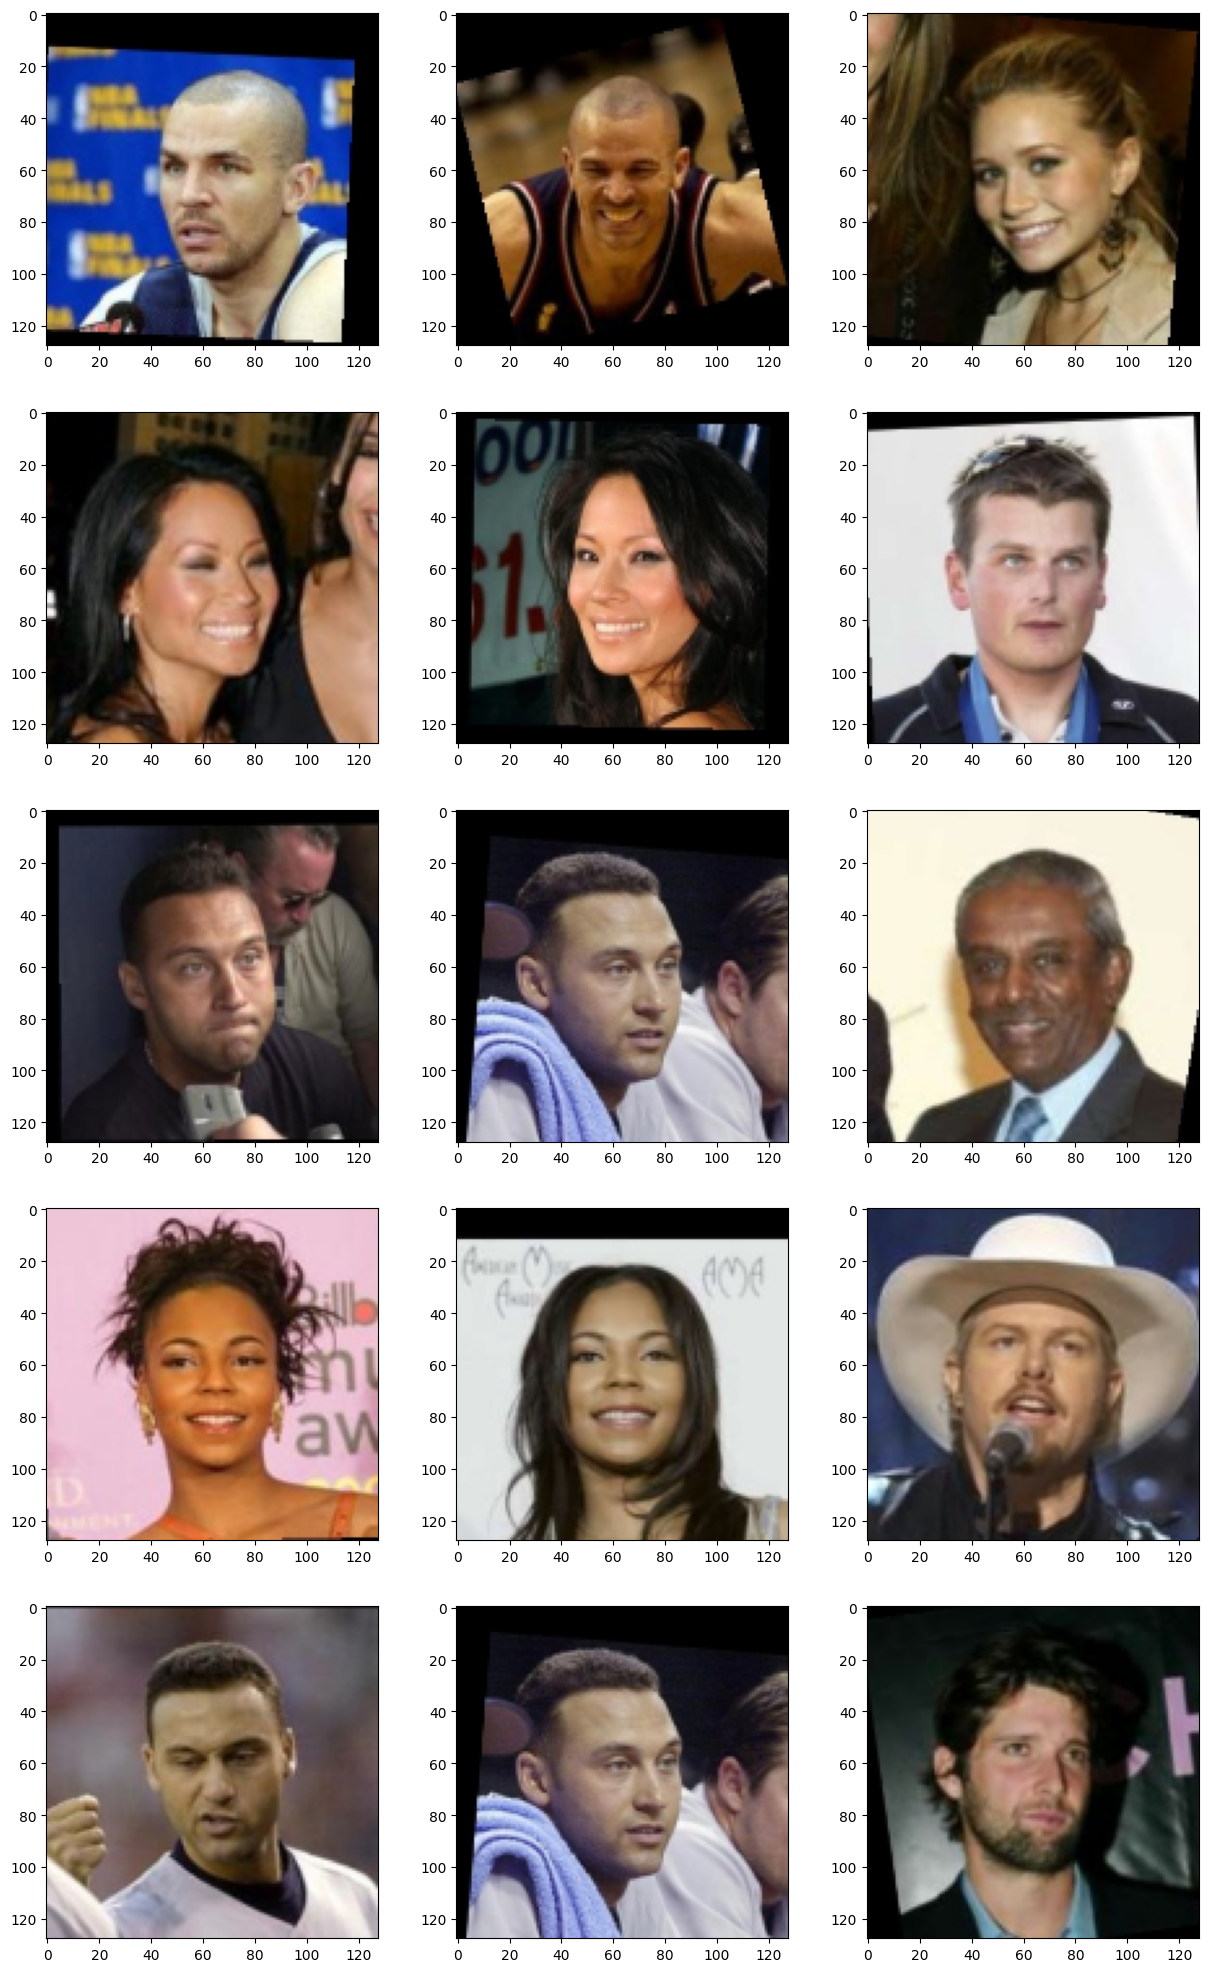

In [16]:
NROWS = 5

fig, axes = plt.subplots(nrows=NROWS, ncols=3, figsize=(15, 5*NROWS))

for batch in get_batch(train_triplet, batch_size=NROWS*10):
    anchors, positives, negatives = batch

    indices = random.sample(range(len(anchors)), NROWS)  # Pick randomly triplets

    for i, idx in enumerate(indices):
        axes[i, 0].imshow(anchors[idx])
        axes[i, 1].imshow(positives[idx])
        axes[i, 2].imshow(negatives[idx])

    break

plt.show()

# Building Model

### Custom Pre-trained Model as Embedding Model

Docs: *https://keras.io/api/applications/*

In [17]:
@tf.keras.utils.register_keras_serializable()
def l2_normalize(x):
  import tensorflow as tf
  return tf.math.l2_normalize(x, axis=1)

In [18]:
def get_embedding_model(input_shape, pretrained_model="xception", freeze_percent=0.8):
    inputs = keras.layers.Input(shape=input_shape)

    if pretrained_model == "xception":
        base_model = Xception(input_shape=input_shape, include_top=False, pooling="avg")
        preprocessed_inputs = xception.preprocess_input(inputs)
    elif pretrained_model == "inception_v3":
        base_model = InceptionV3(input_shape=input_shape, include_top=False, pooling="avg")
        preprocessed_inputs = inception_v3.preprocess_input(inputs)

    base_model.trainable = False

    n_layers = len(base_model.layers)
    train_at = int(n_layers * freeze_percent)
    for layer in base_model.layers[train_at:]:
        layer.trainable = True

    x = base_model(preprocessed_inputs, training=False)  # set False to use moving average of mean & variance which are learned before
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    outputs = keras.layers.Lambda(
        l2_normalize,
        output_shape = (128,),
        name="L2_norm"
    )(x)

    model = keras.Model(inputs, outputs, name="Embedding_Model")
    return model

In [19]:
INPUT_SHAPE = TARGET_SIZE + (3,)
INPUT_SHAPE

(128, 128, 3)

In [20]:
embedding_model = get_embedding_model(INPUT_SHAPE)
embedding_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Embedding_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L2_norm (Lambda)                     │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,978,280 (83.84 MB)

 Trainable params: 9,518,136 (36.31 MB)

 Non-trainable params: 12,460,144 (47.53 MB)

In [21]:
base_model = embedding_model.layers[1]

count = 0
for i in base_model.layers:
  if i.trainable == True:
    count +=1

print("Total layers of Base Model :", len(base_model.layers))
print("Total trainable layers of Base Model :", count)

Total layers of Base Model : 133
Total trainable layers of Base Model : 27


### Custom a new layer class that extends from keras.layers.Layer

*https://keras.io/api/layers/base_layer/#layer-class*

In [22]:
class DistanceLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.norm(anchor - positive, ord="euclidean", axis=1)
        an_distance = tf.norm(anchor - negative, ord="euclidean", axis=1)
        return (ap_distance, an_distance)

### Siamese Network

In [23]:
def get_siamese_network(input_shape):
    embedding_model = get_embedding_model(input_shape)

    anchor_image = keras.layers.Input(input_shape, name="Anchor_Input")  # shape of (None, height, width, channel)
    positive_image = keras.layers.Input(input_shape, name="Positive_Input")
    negative_image = keras.layers.Input(input_shape, name="Negative_Input")

    anchor_vector = embedding_model(anchor_image)  # shape of (None, n_features)
    positive_vector = embedding_model(positive_image)
    negative_vector = embedding_model(negative_image)

    distances = DistanceLayer(name="Distances")(anchor_vector, positive_vector, negative_vector)  # tupe of 2 tensors, shape of (None, )

    model = keras.Model(
        inputs=[anchor_image, positive_image, negative_image],
        outputs=distances,
        name="Siamese_Network"
    )
    return model

In [24]:
siamese_network = get_siamese_network(INPUT_SHAPE)
siamese_network.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Anchor_Input (InputLayer) │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Positive_Input            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Negative_Input            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding_Model           │ (None, 128)            │     21,978,280 │ Anchor_Input[0][0],    │
│ (Functional)              │                        │                │ Positive_Input[0][0],  │
│                           │                        │                │ Negative_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Distances (DistanceLayer) │ [(None), (None)]       │              0 │ Embedding_Model[0][0], │
│                           │                        │                │ Embedding_Model[1][0], │
│                           │                        │                │ Embedding_Model[2][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,978,280 (83.84 MB)

 Trainable params: 9,518,136 (36.31 MB)

 Non-trainable params: 12,460,144 (47.53 MB)

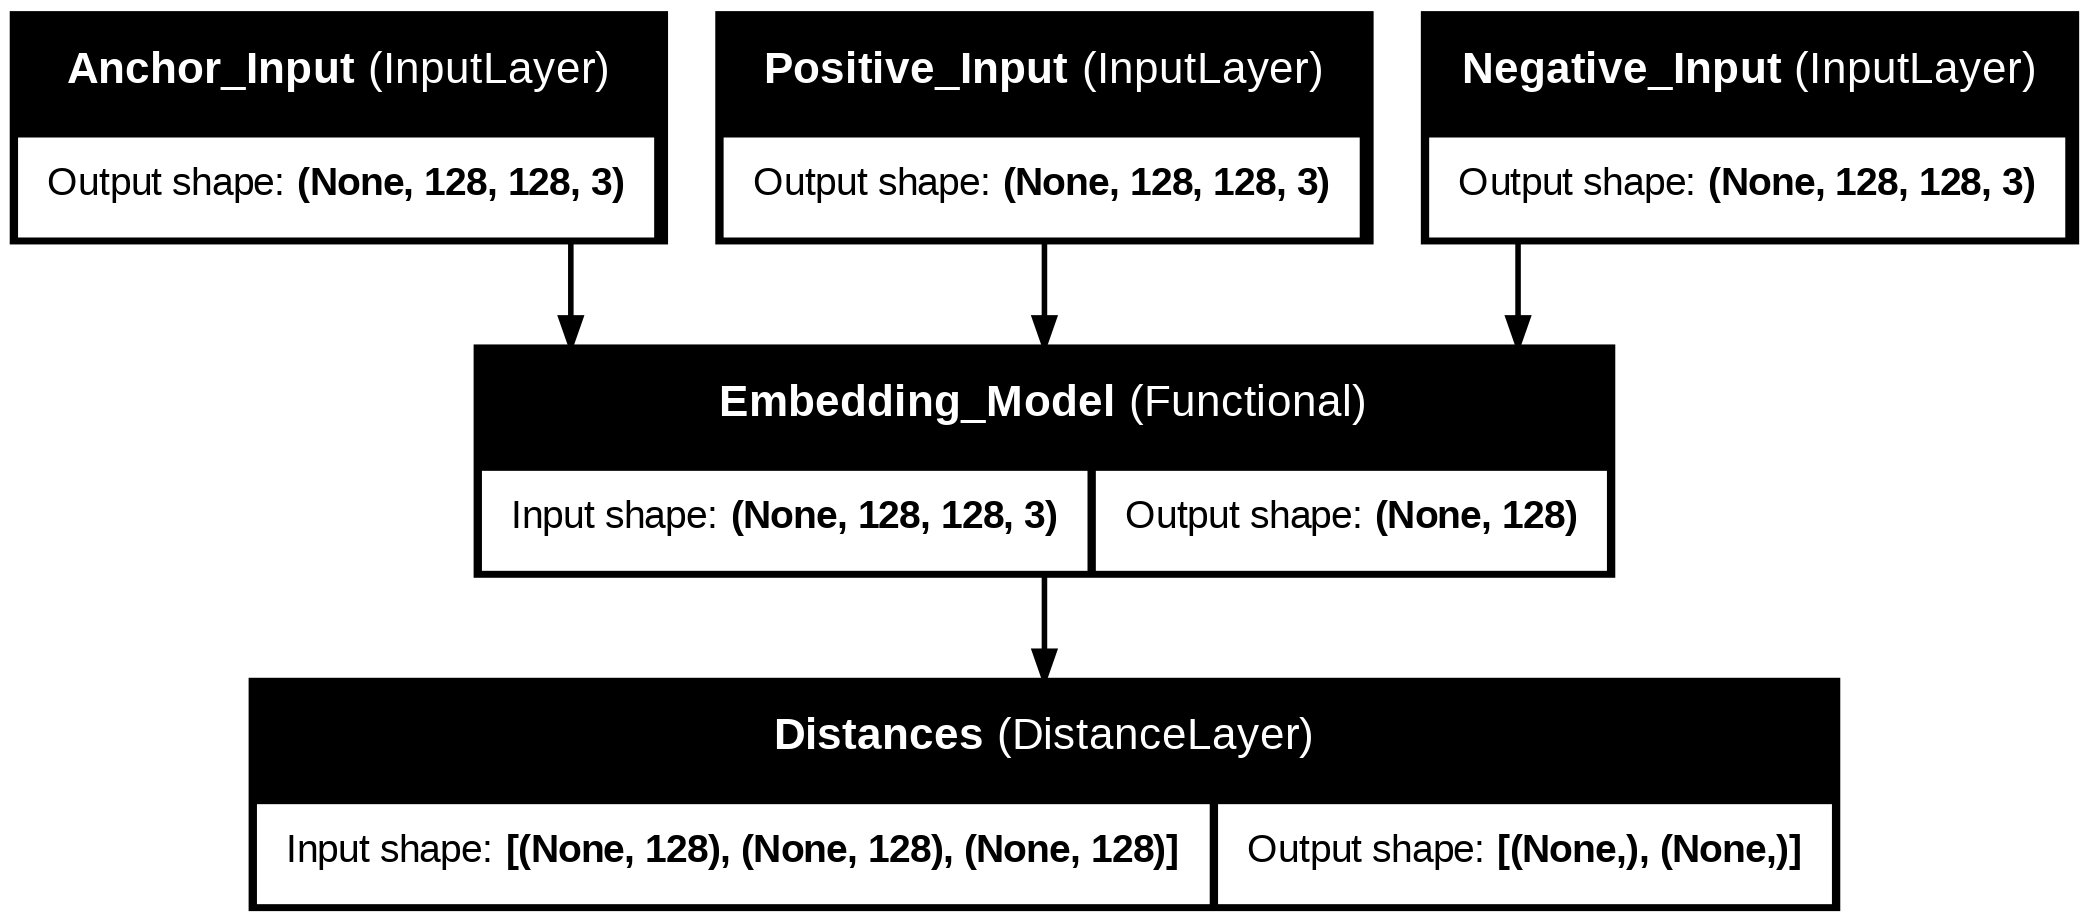

In [25]:
from IPython.display import Image, display

dot = keras.utils.model_to_dot(siamese_network,show_shapes=True, show_layer_names=True, expand_nested=False)
display(Image(dot.create_png()))

### Custom a Model Class that extends from keras.models.Model

*https://keras.io/api/models/model/#model-class*

Custom `train_step()` & `metrics`: *https://keras.io/guides/custom_train_step_in_tensorflow*

In [26]:
class SiameseNetwork(keras.models.Model):
  def __init__(self, siamese_network, margin):
    super().__init__()
    self.siamese_network = siamese_network
    self.margin = margin
    # Training metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.acc_tracker = keras.metrics.Mean(name="accuracy")
    # Validation metrics
    self.val_loss_tracker = keras.metrics.Mean(name="val_loss")
    self.val_acc_tracker = keras.metrics.Mean(name="val_accuracy")
    self.val_ap_dist_tracker = keras.metrics.Mean(name="val_ap_distance")
    self.val_an_dist_tracker = keras.metrics.Mean(name="val_an_distance")
    self.val_ap_std_tracker = keras.metrics.Mean(name="val_ap_std")
    self.val_an_std_tracker = keras.metrics.Mean(name="val_an_std")


  # override call
  def call(self, inputs):
    """Forward pass through the siamese network"""
    anchor, positive, negative = inputs
    return self.siamese_network([anchor, positive, negative])


  def _compute_loss(self, inputs):
    """Compute Loss for training set for backward pass"""
    anchor, positive, negative = inputs
    ap_distance, an_distance = self([anchor, positive, negative])  # This calls __call__ which delegates to call()
    loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)  # shape of (None, )
    loss = tf.reduce_mean(loss)
    return loss, ap_distance, an_distance


  # override train_step
  def train_step(self, data):
    """Backward Pass"""
    anchor, positive, negative = self._unpack_data(data)

    # forward pass
    with tf.GradientTape() as tape:
        loss, ap_distance, an_distance = self._compute_loss([anchor, positive, negative])

    # backward pass
    gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

    # caculate metrics to evaluate
    accuracy = tf.reduce_mean(
        tf.cast(
            tf.less(ap_distance, an_distance),
            tf.float32
            )
        )

    # update_state
    self.loss_tracker.update_state(loss)
    self.acc_tracker.update_state(accuracy)

    return {m.name : m.result() for m in self.train_metrics}


  # override test_step
  def test_step(self, data):
    """Compute Loss for validation set"""
    anchor, positive, negative = self._unpack_data(data)

    loss, ap_distance, an_distance = self._compute_loss([anchor, positive, negative])

    # caculate metrics to evaluate
    accuracy = tf.reduce_mean(
        tf.cast(
            tf.less(ap_distance, an_distance),
            tf.float32
            )
        )

    ap_mean = tf.reduce_mean(ap_distance)
    an_mean = tf.reduce_mean(an_distance)

    ap_std = tf.math.reduce_std(ap_distance)
    an_std = tf.math.reduce_std(an_distance)

    # update_state
    self.val_loss_tracker.update_state(loss)
    self.val_acc_tracker.update_state(accuracy)
    self.val_ap_dist_tracker.update_state(ap_mean)
    self.val_an_dist_tracker.update_state(an_mean)
    self.val_ap_std_tracker.update_state(ap_std)
    self.val_an_std_tracker.update_state(an_std)

    return {m.name : m.result() for m in self.val_metrics}


  @property  # to define metrics method behave like a property - just type `self.metrics`, not `self.metrics()`
  def metrics(self):
    """
    Before every epoch begins, Keras calls reset_state() on all metric objects returned by metrics.
    But it just works for model.fit() - IDK!!!
    """
    return self.train_metrics + self.val_metrics

  def reset_metrics(self):  # redundant but just for clarity
    for metric in self.metrics:
        metric.reset_state()

  @property
  def train_metrics(self):
      return [self.loss_tracker, self.acc_tracker]

  @property
  def val_metrics(self):
      return [
          self.val_loss_tracker, self.val_acc_tracker,
          self.val_ap_dist_tracker, self.val_an_dist_tracker,
          self.val_ap_std_tracker, self.val_an_std_tracker
      ]


  def _unpack_data(self, data):
    """Helper method to unpack different input formats"""
    # Case 1: data comes as ((anchor, positive, negative), None, None)
    if (isinstance(data, (list, tuple)) and len(data) == 3 and
        isinstance(data[0], (list, tuple)) and len(data[0]) == 3 and
        data[1] is None and data[2] is None):
        anchor, positive, negative = data[0]
    # Case 2: data comes as (anchor, positive, negative)
    elif isinstance(data, (list, tuple)) and len(data) == 3:
        anchor, positive, negative = data
    # Case 3: data comes as ((anchor, positive, negative), labels, weights)
    elif isinstance(data, (list, tuple)) and len(data) == 3 and isinstance(data[0], (list, tuple)):
        anchor, positive, negative = data[0]
    else:
        raise ValueError(
            f"Input should be either:\n"
            "1. (anchor, positive, negative) tuple\n"
            "2. ((anchor, positive, negative), None, None)\n"
            "3. ((anchor, positive, negative), labels, weights) format\n"
            f"Got: {type(data)} with length {len(data)}"
        )

    # Verify all are tensors/arrays
    for input in [anchor, positive, negative]:
        if not isinstance(input, (tf.Tensor, np.ndarray)):
            raise TypeError(f"Expected tensor/array, got {type(input)}")

    return anchor, positive, negative

# Training

In [27]:
final_model = SiameseNetwork(siamese_network, margin=0.2)

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

In [28]:
MIN_LOSS = float("inf")
BEST_EPOCH = 0
PATIENCE = 10       # Number of epochs to wait before stopping if no improvement
MIN_DELTA = 0.001   # Minimum improvement to consider as significant

EPOCHS = 100
BATCH_SIZE = 128

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
val_ap_distance = []
val_an_distance = []
val_ap_std = []
val_an_std = []

wait = 0
for epoch in range(1, EPOCHS+1):
    # timer
    start_time = time.time()

    # Reset all metrics at start of epoch
    final_model.reset_metrics()

    # Training
    for data in get_batch(train_triplet, batch_size=BATCH_SIZE):
      metrics = final_model.train_on_batch(data, return_dict=True)  # metrics got from train_step()

    # Validation
    for data in get_batch(val_triplet, batch_size=BATCH_SIZE):
      metrics = final_model.test_on_batch(data, return_dict=True)  # metrics got from test_step()

    # Append metrics of each epoch to list
    train_loss.append(final_model.loss_tracker.result().numpy())
    train_accuracy.append(final_model.acc_tracker.result().numpy())
    val_loss.append(final_model.val_loss_tracker.result().numpy())
    val_accuracy.append(final_model.val_acc_tracker.result().numpy())
    val_ap_distance.append(final_model.val_ap_dist_tracker.result().numpy())
    val_an_distance.append(final_model.val_an_dist_tracker.result().numpy())
    val_ap_std.append(final_model.val_ap_std_tracker.result().numpy())
    val_an_std.append(final_model.val_an_std_tracker.result().numpy())

    # Save the best weights or full model
    if val_loss[-1] <= MIN_LOSS - MIN_DELTA:
      final_model.save_weights("siamese_network.weights.h5")
      MIN_LOSS = val_loss[-1]
      BEST_EPOCH = epoch
      wait = 0  # Reset counter when improvement is found
    else:
      wait += 1

    # Print each epoch
    epoch_time = time.time() - start_time
    print(
        f"Epoch {epoch}/{EPOCHS} ({epoch_time:.1f}s) - "
        f"Loss: {train_loss[-1]:.4f} - "
        f"Val Loss: {val_loss[-1]:.4f} - "
        f"Acc: {train_accuracy[-1]:.4f} - "
        f"Val Acc: {val_accuracy[-1]:.4f}"
        )

    # Early stopping
    if wait >= PATIENCE:
      print("---")
      print(f"Early stopping at epoch {epoch} - no significant improvement of 'val_loss' for {PATIENCE} epochs")
      break

Epoch 1/100 (246.6s) - Loss: 0.0726 - Val Loss: 0.0533 - Acc: 0.8496 - Val Acc: 0.8953
Epoch 2/100 (174.0s) - Loss: 0.0396 - Val Loss: 0.0466 - Acc: 0.9226 - Val Acc: 0.9090
Epoch 3/100 (173.2s) - Loss: 0.0204 - Val Loss: 0.0480 - Acc: 0.9655 - Val Acc: 0.9044
Epoch 4/100 (175.1s) - Loss: 0.0107 - Val Loss: 0.0452 - Acc: 0.9846 - Val Acc: 0.9086
Epoch 5/100 (173.3s) - Loss: 0.0058 - Val Loss: 0.0446 - Acc: 0.9937 - Val Acc: 0.9100
Epoch 6/100 (174.2s) - Loss: 0.0036 - Val Loss: 0.0434 - Acc: 0.9972 - Val Acc: 0.9089
Epoch 7/100 (174.1s) - Loss: 0.0023 - Val Loss: 0.0446 - Acc: 0.9986 - Val Acc: 0.9098
Epoch 8/100 (173.7s) - Loss: 0.0016 - Val Loss: 0.0448 - Acc: 0.9990 - Val Acc: 0.9112
Epoch 9/100 (174.4s) - Loss: 0.0014 - Val Loss: 0.0423 - Acc: 0.9993 - Val Acc: 0.9146
Epoch 10/100 (174.4s) - Loss: 0.0011 - Val Loss: 0.0426 - Acc: 0.9999 - Val Acc: 0.9132
Epoch 11/100 (173.9s) - Loss: 0.0007 - Val Loss: 0.0401 - Acc: 0.9999 - Val Acc: 0.9179
Epoch 12/100 (173.2s) - Loss: 0.0005 - Va

In [29]:
print(f"The best epoch is {BEST_EPOCH} where the lowest 'val_loss' = {MIN_LOSS:.4f}")

The best epoch is 11 where the lowest 'val_loss' = 0.0401


# Evaluate Model

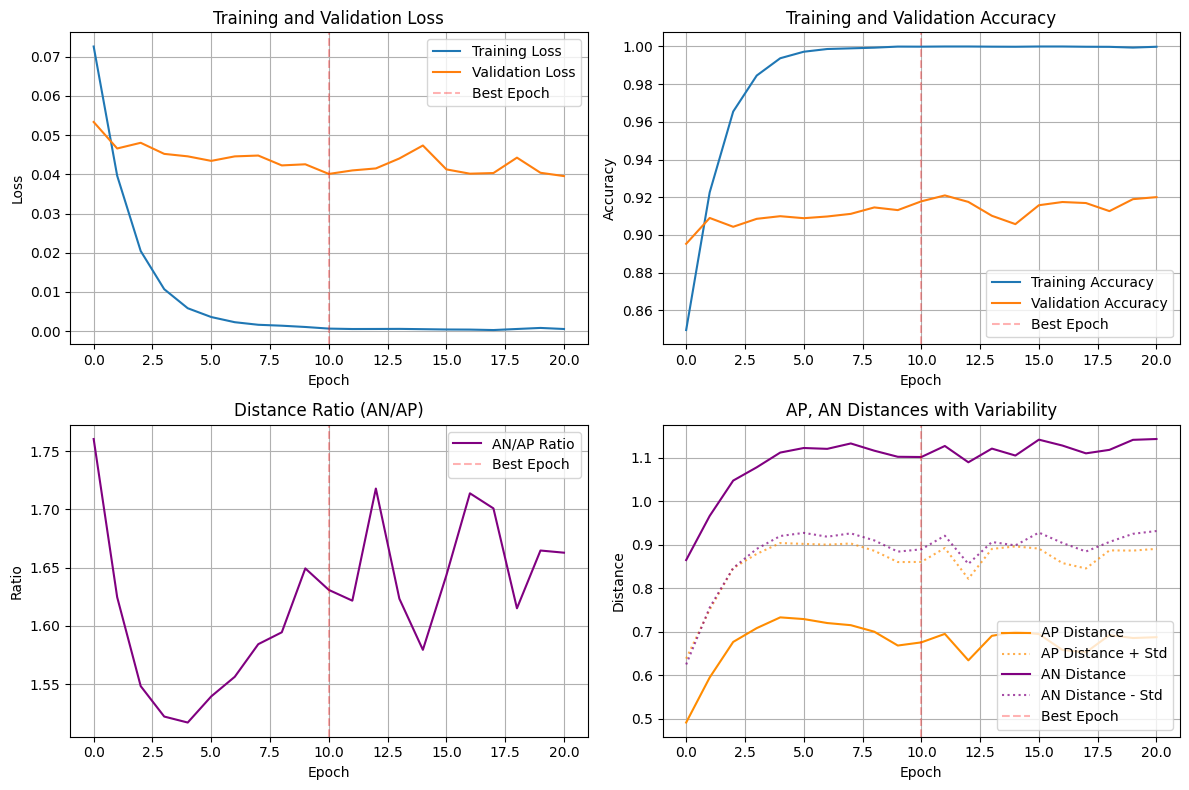

In [30]:
plt.figure(figsize=(12,8))

# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Distance + Std
plt.subplot(2, 2, 4)
plt.plot(val_ap_distance, label='AP Distance', color='darkorange')
plt.plot(np.array(val_ap_distance) + np.array(val_ap_std),
         label='AP Distance + Std',  # or 'AP Upper Bound'
         linestyle=':', color='darkorange', alpha=0.7)

plt.plot(val_an_distance, label='AN Distance', color='purple')
plt.plot(np.array(val_an_distance) - np.array(val_an_std),
         label='AN Distance - Std',  # or 'AN Lower Bound'
         linestyle=':', color='purple', alpha=0.7)
plt.title('AP, AN Distances with Variability')
plt.xlabel('Epoch')
plt.ylabel('Distance')
plt.legend()

# Distance Ratio Plot (AN/AP)
plt.subplot(2, 2, 3)
distance_ratio = [an/ap for an, ap in zip(val_an_distance, val_ap_distance)]
plt.plot(distance_ratio, label='AN/AP Ratio', color='purple')
plt.title('Distance Ratio (AN/AP)')
plt.xlabel('Epoch')
plt.ylabel('Ratio')

# Highlight best epoch on all plots
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.axvline(x=BEST_EPOCH-1, color='r', linestyle='--', alpha=0.3, label='Best Epoch')
    plt.legend()
    plt.grid()


plt.tight_layout()
plt.show()

# Extract Embedding Model from Siamese Network

In [31]:
pretrained_siamese_network = get_siamese_network(INPUT_SHAPE)
pretrained_final_model = SiameseNetwork(pretrained_siamese_network, margin=1.0)

In [32]:
# Build inputs first to load weights
pretrained_final_model.build([
    tf.TensorShape([None, *INPUT_SHAPE]),  # anchor
    tf.TensorShape([None, *INPUT_SHAPE]),  # positive
    tf.TensorShape([None, *INPUT_SHAPE])   # negative
])

pretrained_final_model.load_weights("siamese_network.weights.h5")

In [33]:
pretrained_siamese_network = pretrained_final_model.siamese_network
pretrained_siamese_network.layers

[<InputLayer name=Anchor_Input, built=True>,
 <InputLayer name=Positive_Input, built=True>,
 <InputLayer name=Negative_Input, built=True>,
 <Functional name=Embedding_Model, built=True>,
 <DistanceLayer name=Distances, built=True>]

In [34]:
pretrained_embedding_model = pretrained_siamese_network.layers[3]
pretrained_embedding_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Functional name=xception, built=True>,
 <Dense name=dense_4, built=True>,
 <BatchNormalization name=batch_normalization_14, built=True>,
 <Dense name=dense_5, built=True>,
 <Lambda name=L2_norm, built=True>]

In [35]:
pretrained_embedding_model.save("embedding_model.keras")

In [36]:
loaded_model = keras.models.load_model("embedding_model.keras")

loaded_model.summary()

Model: "Embedding_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L2_norm (Lambda)                     │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,978,280 (83.84 MB)

 Trainable params: 9,518,136 (36.31 MB)

 Non-trainable params: 12,460,144 (47.53 MB)

In [37]:
from google.colab import files
files.download("embedding_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Choosing threshold

In [38]:
def predict_similarity(orginal_face, test_face, threshold, model=loaded_model):
  orginal_feature_vector = model.predict(orginal_face, verbose=0)  # shape of (None, n_features)
  test_feature_vector = model.predict(test_face, verbose=0)

  distance = np.sum(np.square(orginal_feature_vector - test_feature_vector), axis=-1)  # Shape of (None, )

  prediction = np.where(distance < threshold, 0, 1)  # shape of (None, )
  return prediction

In [39]:
threshold_range = np.arange(0.1, 1.9, 0.1)

tsr = []
fsr = []

for threshold in threshold_range:
  start_time = time.time()

  all_labels = []
  all_preds = []

  for i, data in enumerate(get_batch(test_triplet, batch_size=516), start=1):
    anchor, positive, negative = data
    pred_positive_arr = predict_similarity(anchor, positive, threshold=threshold)
    pred_negative_arr = predict_similarity(anchor, negative, threshold=threshold)

    all_labels.extend([0] * len(pred_positive_arr) + [1] * len(pred_negative_arr))
    all_preds.extend(np.append(pred_positive_arr, pred_negative_arr))

    #if i == 4:  # Limit batches
      #break

  all_labels = np.array(all_labels)
  all_preds = np.array(all_preds)

  cm = confusion_matrix(all_labels, all_preds)

  true_similarity = cm[0, 0]
  false_difference = cm[0, 1]
  false_similarity = cm[1, 0]
  true_difference = cm[1, 1]

  true_similarity_rate = true_similarity / (true_similarity + false_difference) if (true_similarity + false_difference) != 0 else 0
  false_similarity_rate = false_similarity / (false_similarity + true_difference) if (false_similarity + true_difference) != 0 else 0

  # Append
  tsr.append(true_similarity_rate)
  fsr.append(false_similarity_rate)

  # Print progress
  end_time = time.time()
  print(f"Threshold: {threshold:.2f}, Time: {end_time - start_time:.2f}s")

Threshold: 0.10, Time: 45.63s
Threshold: 0.20, Time: 36.81s
Threshold: 0.30, Time: 35.84s
Threshold: 0.40, Time: 35.03s
Threshold: 0.50, Time: 35.18s
Threshold: 0.60, Time: 35.83s
Threshold: 0.70, Time: 35.14s
Threshold: 0.80, Time: 34.52s
Threshold: 0.90, Time: 35.17s
Threshold: 1.00, Time: 35.07s
Threshold: 1.10, Time: 35.02s
Threshold: 1.20, Time: 37.86s
Threshold: 1.30, Time: 42.14s
Threshold: 1.40, Time: 36.85s
Threshold: 1.50, Time: 35.94s
Threshold: 1.60, Time: 37.06s
Threshold: 1.70, Time: 34.39s
Threshold: 1.80, Time: 34.44s


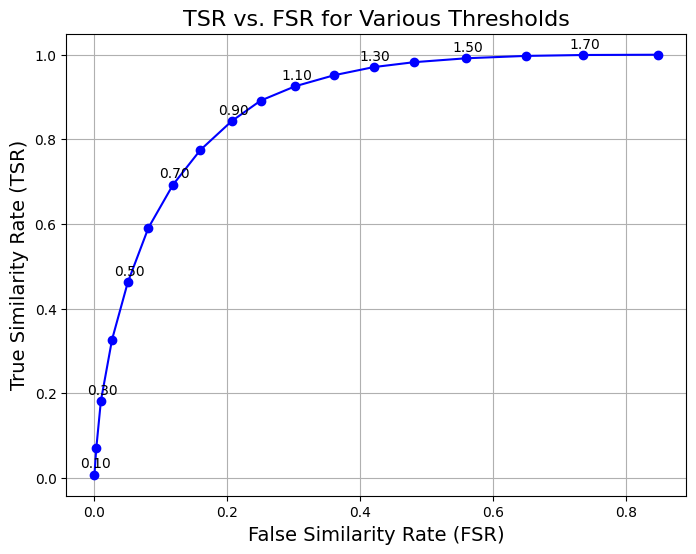

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fsr, tsr, marker='o', color='blue', linestyle='-')

# annotate each point with its threshold
for i, threshold in enumerate(threshold_range):
  if i % 2 == 0:
    plt.annotate(f'{threshold:.2f}', (fsr[i], tsr[i]),
                 textcoords="offset points", xytext=(-10,5)
                 )

plt.xlabel('False Similarity Rate (FSR)', fontsize=14)
plt.ylabel('True Similarity Rate (TSR)', fontsize=14)
plt.title('TSR vs. FSR for Various Thresholds', fontsize=16)
plt.grid(True)
plt.show()

In [63]:
BEST_THRESHOLD = 0.8

# Test

In [64]:
def plot_confusion_matrix(pred_positive_arr, pred_negative_arr):
  true = np.array([0] * len(pred_positive_arr) + [1] * len(pred_negative_arr))  # Similarity is 0, and Difference is 1
  pred = np.append(pred_positive_arr, pred_negative_arr)

  print(classification_report(true, pred))

  cm = confusion_matrix(true, pred)

  categories = ["Similarity", "Difference"]  # Similarity first, then Difference
  cell_names = ["True Similarity", 'False Difference', 'False Similarity','True Difference']
  cell_values = cm.flatten()
  cell_percentages = ['{:.2%}'.format(i) for i in cm.flatten() / np.sum(cm)]

  cell_labels = [f'{cell_name}\n\n{value} images\n({percentage} of total images)'
                 for cell_name, value, percentage in zip(cell_names, cell_values, cell_percentages)
                 ]
  cell_labels = np.asarray(cell_labels).reshape(2, 2)  # asarray to avoid create new array when is already an array

  sns.heatmap(cm, annot=cell_labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
  plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [66]:
pred_positive_list = []
pred_negative_list = []

for data in get_batch(test_triplet, batch_size=512):
    anchor, positive, negative = data

    pred_positive_list.extend(predict_similarity(anchor, positive, threshold=BEST_THRESHOLD))
    pred_negative_list.extend(predict_similarity(anchor, negative, threshold=BEST_THRESHOLD))

pred_positive_arr = np.array(pred_positive_list)
pred_negative_arr = np.array(pred_negative_list)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      4645
           1       0.79      0.84      0.81      4645

    accuracy                           0.81      9290
   macro avg       0.81      0.81      0.81      9290
weighted avg       0.81      0.81      0.81      9290



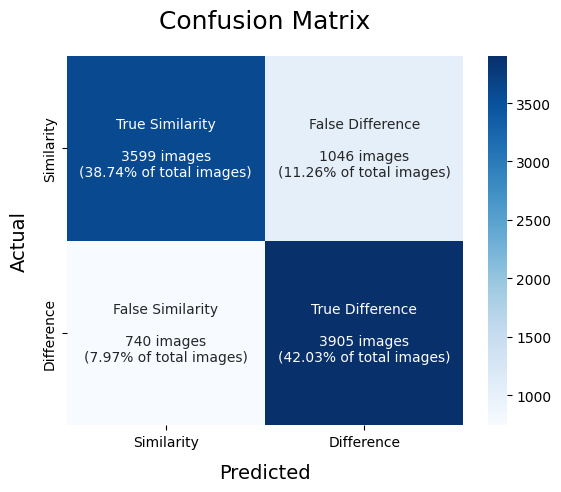

In [67]:
plot_confusion_matrix(pred_positive_arr, pred_negative_arr)